# Sampling Weights

## Libraries & Functions Import

In [40]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

#import functions from my scripts and book scripts

sys.path.append('../../scripts')
from AFML_book_scripts import *
from AFML_my_scripts import *

## Data Handling

### Import

In [21]:
data = pd.read_csv('../../data/SP_futures_tick_data.csv')
#combine 'date' and 'time' strings into one column
datetime_str = data['date'] + ' ' + data['time']
#convert the combined string to datetime format
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')


### Create Bars and Events

In [22]:
#2019 data only to speed up testing

data = data[data.datetime.dt.year >= 2019]
#before 2020
data = data[data.datetime.dt.year <= 2020]
#drop date and time 
data = data.drop(['date','time'],axis=1)
print(f'Now, data starts at {data.datetime.iloc[0]} and ends at {data.datetime.iloc[-1]}')
data = data.reset_index()

Now, data starts at 2019-01-01 17:01:44.013000 and ends at 2019-12-31 15:03:41.206000


In [25]:
bars = VolumeBarsDfVectorized(data,volume_per_bar=500)
bars = bars.rename(columns={'end_date':'datetime'})
bars = bars.drop('start_date',axis=1)
bars = bars.set_index('datetime')
#calculate daily volatility and add it to the bars DataFrame
bars['daily_vol'] = GetDailyVol(bars['close'], span0=100)
bars.head()

,open,high,low,close,volume,daily_vol
datetime,,,,,,
2019-01-03 08:06:25.211,2511.4,2519.0,2454.2,2487.0,505,NaN
2019-01-10 03:12:02.618,2487.0,2595.0,2439.0,2565.3,495,NaN
2019-01-17 07:59:30.327,2565.3,2626.0,2563.0,2606.2,500,0.010989
2019-01-24 03:55:36.130,2606.2,2677.2,2606.2,2644.5,500,0.009310
2019-02-05 05:21:23.412,2645.0,2728.0,2627.0,2727.8,500,0.009355


In [26]:
#here we label the entire dataset
close = bars['close'] #closing prices series indexed by datetime
events = pd.DataFrame(index = bars.close.index)
events['t1'] = close.index.to_series().shift(-10) #set vert barrier 10 bars ahead
target = 0.02 #2% fixed as target 
events['trgt'] = target #target calcualted by gettarget
events['side'] = 1  #long only
tpsl_here = (1,1) #symmetric positioning tp and sl
events.head()

,t1,trgt,side
datetime,,,
2019-01-03 08:06:25.211,2019-05-03 03:34:46.667,0.02,1
2019-01-10 03:12:02.618,2019-05-08 07:50:03.613,0.02,1
2019-01-17 07:59:30.327,2019-05-13 07:09:25.433,0.02,1
2019-01-24 03:55:36.130,2019-05-20 17:58:09.632,0.02,1
2019-02-05 05:21:23.412,2019-05-29 04:22:32.714,0.02,1


## NUMBER OF CONCURRENT LABELS

In [27]:
t1 = events['t1']
# Price bar timestamps
closeIdx = bars.index
# Molecule = all event start times
molecule = t1.index

# Step 1: Compute concurrent counts
concurrent_counts = mpNumCoEvents(closeIdx, t1, molecule)
concurrent_counts

datetime
2019-01-03 08:06:25.211     1
2019-01-10 03:12:02.618     2
2019-01-17 07:59:30.327     3
2019-01-24 03:55:36.130     4
2019-02-05 05:21:23.412     5
2019-02-19 02:47:39.099     6
2019-03-04 02:48:55.404     7
2019-03-14 20:43:19.748     8
2019-03-28 02:05:05.213     9
2019-04-12 05:39:02.208    10
2019-05-03 03:34:46.667    11
2019-05-08 07:50:03.613    11
2019-05-13 07:09:25.433    11
2019-05-20 17:58:09.632    11
2019-05-29 04:22:32.714    11
2019-06-04 03:00:19.705    11
2019-06-18 03:42:59.329    11
2019-07-03 05:00:02.360    11
2019-07-31 01:15:58.479    11
2019-08-05 17:05:33.515    11
2019-08-08 17:30:22.278    11
2019-08-15 06:31:42.298    11
2019-08-23 07:14:51.447    11
2019-08-27 06:08:24.058    11
2019-09-05 06:00:17.144    11
2019-09-25 04:10:54.709    11
2019-10-09 07:37:17.869    11
2019-10-21 08:12:34.852    11
2019-11-24 17:46:13.195    11
dtype: int64

## AVERAGE UNIQUENESS OF A LABEL

In [28]:
avg_uniqueness = sampleTW(t1, concurrent_counts, molecule)
avg_uniqueness

datetime
2019-01-03 08:06:25.211    0.274534
2019-01-10 03:12:02.618    0.191890
2019-01-17 07:59:30.327    0.154700
2019-01-24 03:55:36.130    0.132661
2019-02-05 05:21:23.412    0.118198
2019-02-19 02:47:39.099    0.108281
2019-03-04 02:48:55.404    0.101394
2019-03-14 20:43:19.748    0.096671
2019-03-28 02:05:05.213    0.093572
2019-04-12 05:39:02.208    0.091736
2019-05-03 03:34:46.667    0.090909
2019-05-08 07:50:03.613    0.090909
2019-05-13 07:09:25.433    0.090909
2019-05-20 17:58:09.632    0.090909
2019-05-29 04:22:32.714    0.090909
2019-06-04 03:00:19.705    0.090909
2019-06-18 03:42:59.329    0.090909
2019-07-03 05:00:02.360    0.090909
2019-07-31 01:15:58.479    0.090909
2019-08-05 17:05:33.515    0.090909
2019-08-08 17:30:22.278    0.090909
2019-08-15 06:31:42.298    0.090909
2019-08-23 07:14:51.447    0.090909
2019-08-27 06:08:24.058    0.090909
2019-09-05 06:00:17.144    0.090909
2019-09-25 04:10:54.709    0.090909
2019-10-09 07:37:17.869    0.090909
2019-10-21 08:12:34

## BAGGING CLASSIFIERS AND UNIQUENESS

In [ ]:
indM = getIndMatrix(bars.index, t1)

In [32]:
indM.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-03 08:06:25.211,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-10 03:12:02.618,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-17 07:59:30.327,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-24 03:55:36.130,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-02-05 05:21:23.412,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
avg_uniqueness = getAvgUniqueness(indM)
avg_uniqueness.head()

0    0.274534
1    0.191890
2    0.154700
3    0.132661
4    0.118198
dtype: float64

In [35]:
phi = seqBootstrap(indM)
phi

[np.int64(23),
 np.int64(28),
 np.int64(20),
 np.int64(0),
 np.int64(6),
 np.int64(16),
 np.int64(8),
 np.int64(19),
 np.int64(8),
 np.int64(7),
 np.int64(15),
 np.int64(2),
 np.int64(7),
 np.int64(1),
 np.int64(20),
 np.int64(0),
 np.int64(12),
 np.int64(23),
 np.int64(20),
 np.int64(13),
 np.int64(16),
 np.int64(7),
 np.int64(21),
 np.int64(9),
 np.int64(8),
 np.int64(21),
 np.int64(6),
 np.int64(8),
 np.int64(16)]

In [36]:
def getRndT1(numObs, numBars, maxH):
    """
    Generate a random t1 Series for numObs observations.
    Each observation starts at a random bar and spans a random number of bars.

    Returns a sorted pandas Series: index = start bar (t0), value = end bar (t1)
    """
    t1 = pd.Series(dtype=int)
    for _ in range(numObs):
        ix = np.random.randint(0, numBars)               # random start bar
        val = ix + np.random.randint(1, maxH+1)         # end bar (span at least 1)
        t1.loc[ix] = val
    return t1.sort_index()

# Example usage:
rnd_t1 = getRndT1(numObs=10, numBars=10, maxH=4)
print(rnd_t1)


0     2
2     6
3     4
4     8
5     8
7    11
dtype: int64


In [ ]:
results = [auxMC(numObs=10, numBars=30, maxH=4) for _ in range(200)]

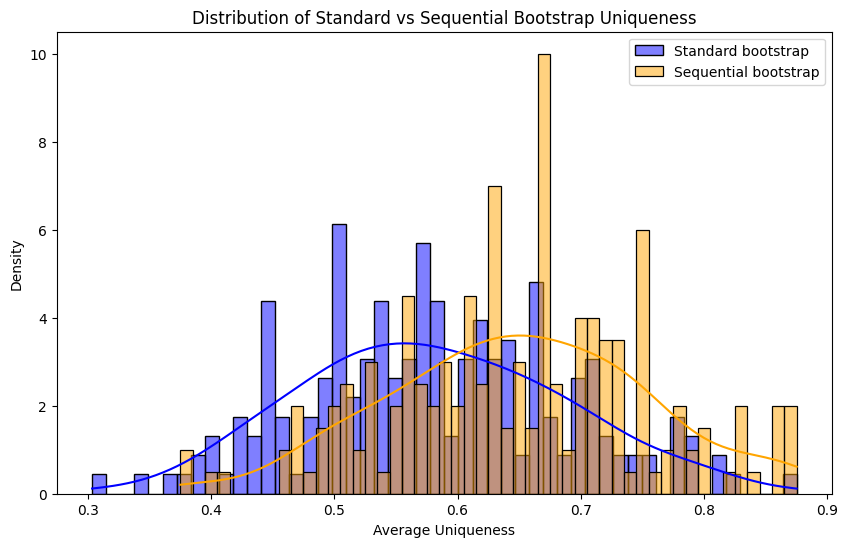

In [ ]:
df = pd.DataFrame(results)

# Plot distributions
plt.figure(figsize=(10,6))
sns.histplot(df['stdU'], color='blue', label='Standard bootstrap', kde=True, stat="density", bins=50)
sns.histplot(df['seqU'], color='orange', label='Sequential bootstrap', kde=True, stat="density", bins=50)
plt.xlabel('Average Uniqueness')
plt.ylabel('Density')
plt.title('Distribution of Standard vs Sequential Bootstrap Uniqueness')
plt.legend()
plt.show()

Observe how the uniqueness is shifted to the right when applying sequential boostrap!

## RETURN ATTRIBUTION

In [ ]:
weights = sampleW(t1, concurrent_counts, bars.close, molecule)
print(weights)

datetime
2019-01-03 08:06:25.211    0.169674
2019-01-10 03:12:02.618    0.163276
2019-01-17 07:59:30.327    0.091019
2019-01-24 03:55:36.130    0.069501
2019-02-05 05:21:23.412    0.044861
2019-02-19 02:47:39.099    0.014502
2019-03-04 02:48:55.404    0.022491
2019-03-14 20:43:19.748    0.024418
2019-03-28 02:05:05.213    0.028430
2019-04-12 05:39:02.208    0.001688
2019-05-03 03:34:46.667    0.002006
2019-05-08 07:50:03.613    0.010432
2019-05-13 07:09:25.433    0.004021
2019-05-20 17:58:09.632    0.006486
2019-05-29 04:22:32.714    0.015692
2019-06-04 03:00:19.705    0.023881
2019-06-18 03:42:59.329    0.021551
2019-07-03 05:00:02.360    0.012393
2019-07-31 01:15:58.479    0.016949
2019-08-05 17:05:33.515    0.012669
2019-08-08 17:30:22.278    0.043944
2019-08-15 06:31:42.298    0.026002
2019-08-23 07:14:51.447    0.035200
2019-08-27 06:08:24.058    0.027145
2019-09-05 06:00:17.144    0.030119
2019-09-25 04:10:54.709    0.019701
2019-10-09 07:37:17.869    0.020429
2019-10-21 08:12:34

1.0 0.0
0.75 0.000946969696969697
0.5 0.001893939393939394
0.09999999999999998 0.0034090909090909094
0.0 0.003787878787878788
-0.11111111111111116 0.004208754208754209
-1.0 0.007575757575757576
-3.0 0.015151515151515152


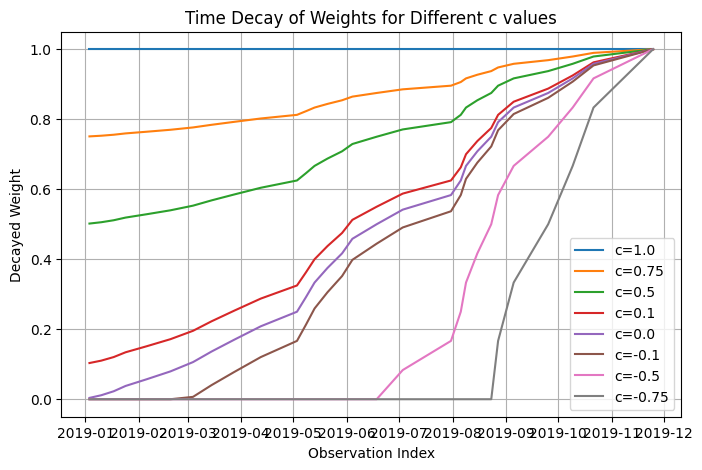

In [46]:
c_values = [1.0, 0.75, 0.5, 0.1, 0.0,-0.1, -0.5,-0.75]
plt.figure(figsize=(8,5))


for c in c_values:
    decayed = getTimeDecay(concurrent_counts, clfLastW=c)
    plt.plot(decayed.index, decayed.values, label=f"c={c}")

plt.title("Time Decay of Weights for Different c values")
plt.xlabel("Observation Index")
plt.ylabel("Decayed Weight")
plt.legend()
plt.grid(True)
plt.show()